C:\Users\hskma\AppData\Local\Temp\ipykernel_5712\665775722.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


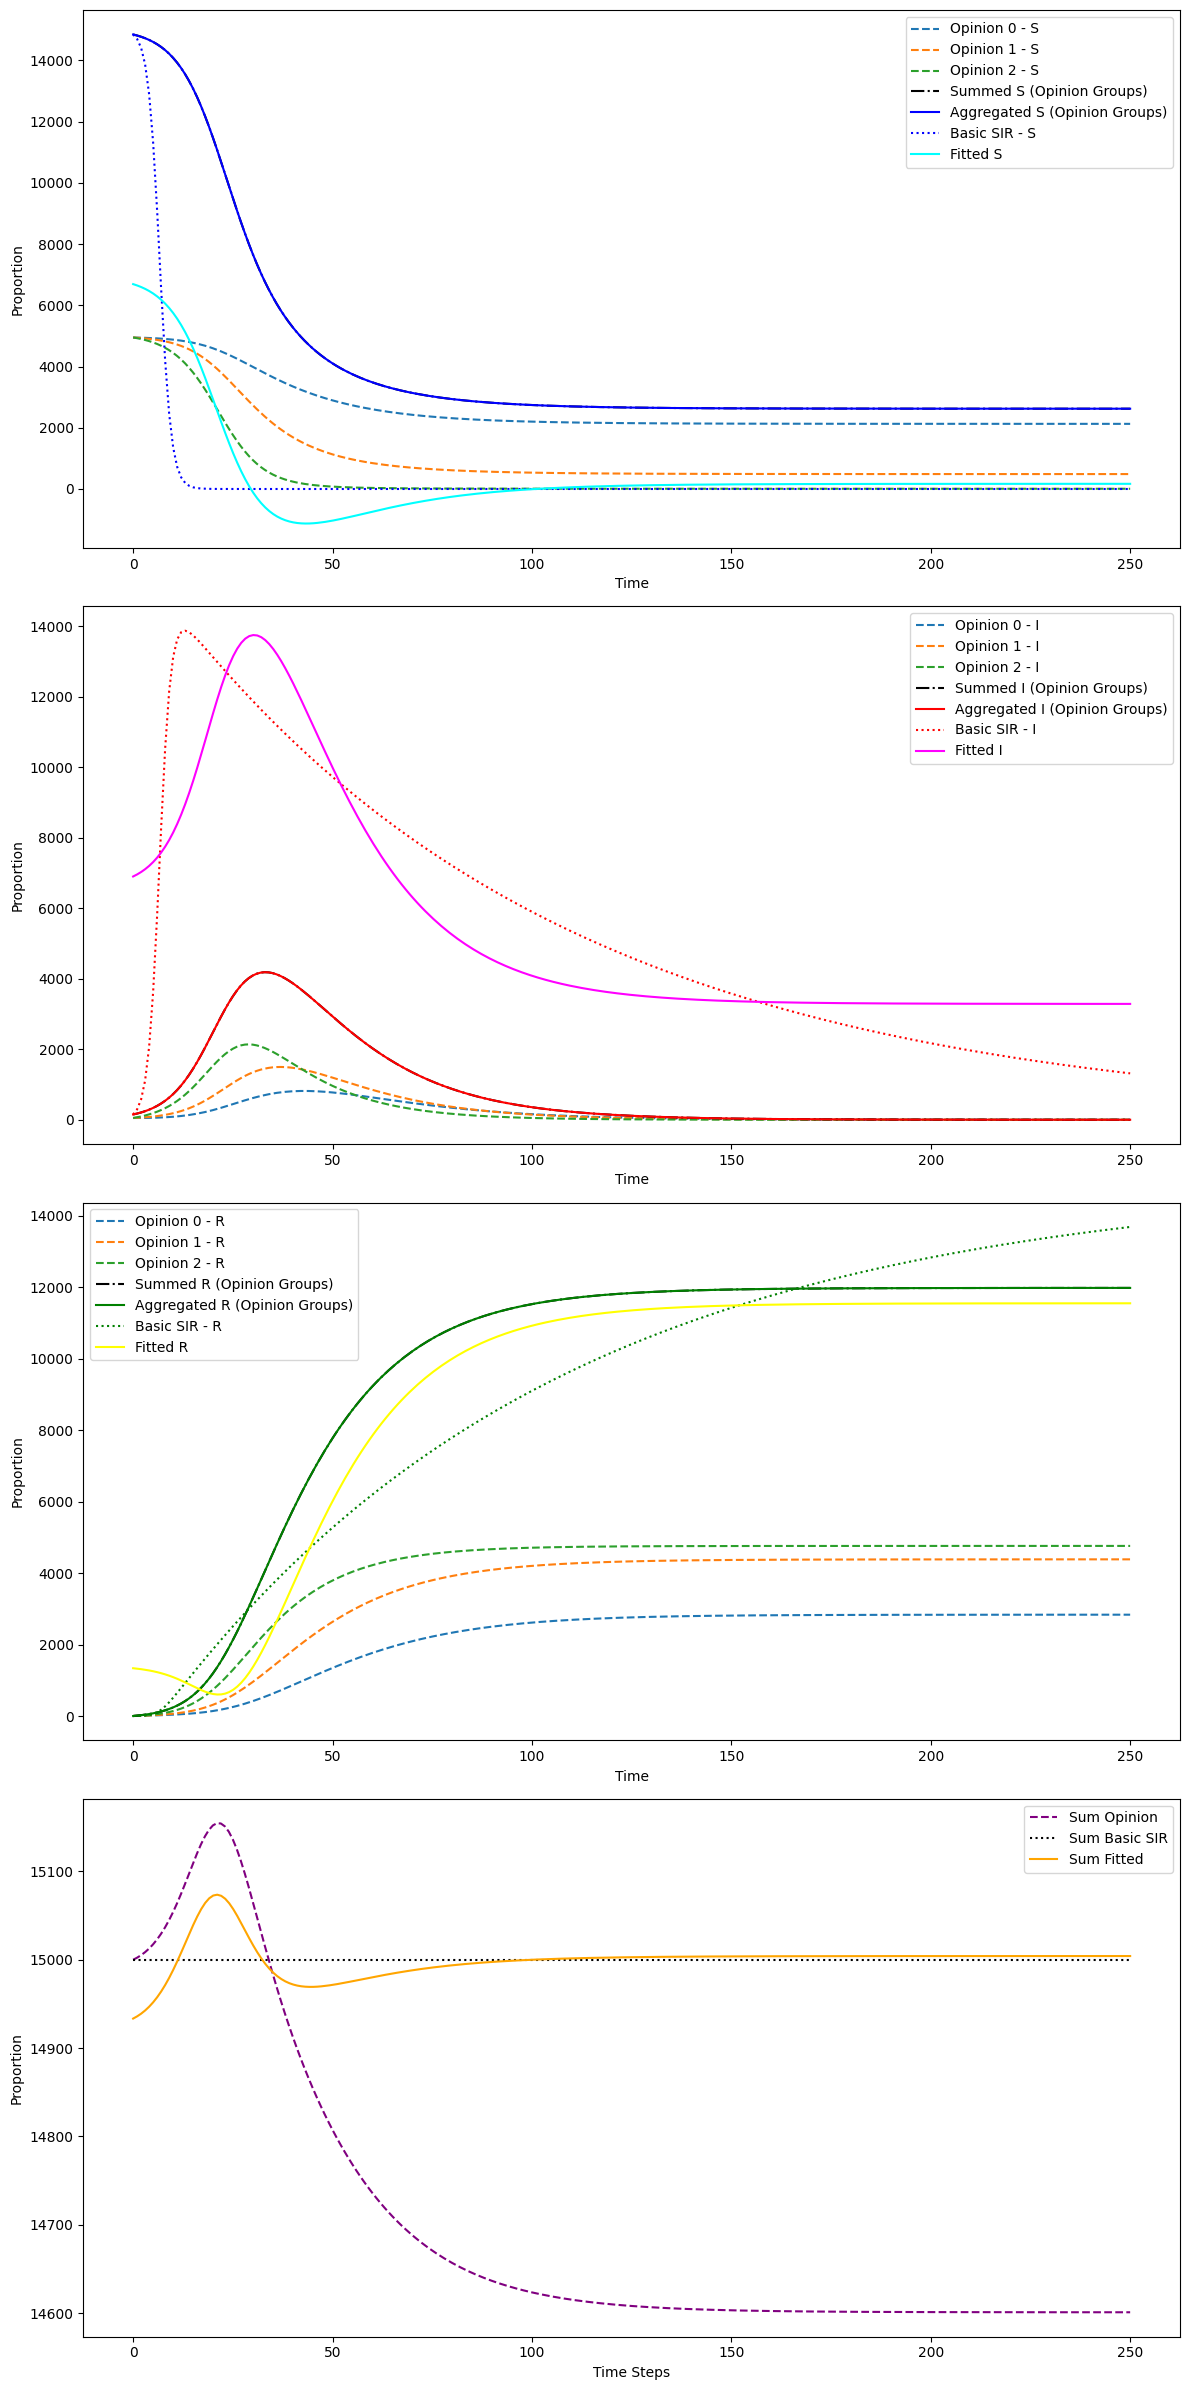

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.7
gamma = 0.01
MaxTime = 250
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))
    

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Convert initial_values to a DataFrame
initial_df = pd.DataFrame([initial_values])


# Differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(t, y, row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N - (3 * n) * gamma * row[f'P_I_{O}']

def dR(t, y, row, O, gamma, n):
    return (3 * n) * gamma * row[f'P_I_{O}']

# Runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        U[j + 1] = U[j] + h * k2

    return U[-1]

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)

    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]
    data = pd.DataFrame(columns=columns)

    row = initial_values.copy()

    # Include the initial values as the first row in the DataFrame
    data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Aggregate the opinion-based model values
def aggregate_opinion_model(data, n):
    aggregated_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    return aggregated_S, aggregated_I, aggregated_R

# Fit a curve using MSE
def mse_curve_fit(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Ensure the RunTime array includes the initial time step
RunTime_extended = np.linspace(0, MaxTime, MaxTime + 1)

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Aggregate the opinion-based model values
aggregated_S, aggregated_I, aggregated_R = aggregate_opinion_model(data, n)

# Fit a curve between aggregated opinion-based model and basic SIR model using MSE
def fit_curve(x, a, b, c):
    return a * x[0] + b * x[1] + c * x[2]

# Exclude the initial values to match the lengths
x_data = np.array([aggregated_S[1:], aggregated_I[1:], aggregated_R[1:]])
y_data_S = basic_S
y_data_I = basic_I
y_data_R = basic_R

popt_S, _ = curve_fit(fit_curve, x_data, y_data_S)
popt_I, _ = curve_fit(fit_curve, x_data, y_data_I)
popt_R, _ = curve_fit(fit_curve, x_data, y_data_R)

fitted_S = fit_curve(x_data, *popt_S)
fitted_I = fit_curve(x_data, *popt_I)
fitted_R = fit_curve(x_data, *popt_R)

# Sum the S, I, and R values for opinion-based, basic, and fitted models
sum_opinion = aggregated_S + aggregated_I + aggregated_R
sum_basic = basic_S + basic_I + basic_R
sum_fitted = fitted_S + fitted_I + fitted_R


# Adjust RunTime to match the lengths
RunTime_fit = RunTime

def plot_simulation_combined(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime_extended, RunTime, sum_opinion, sum_basic, sum_fitted, data, n):
    num_plots = n + 1  # Total number of opinion groups
    fig, axes = plt.subplots(4, 1, figsize=(12, 24))

    # Plot S, I, R for each opinion group
    for i in range(num_plots):
        axes[0].plot(data.index, data[f'P_S_{i}'], label=f'Opinion {i} - S', linestyle='--')
        axes[1].plot(data.index, data[f'P_I_{i}'], label=f'Opinion {i} - I', linestyle='--')
        axes[2].plot(data.index, data[f'P_R_{i}'], label=f'Opinion {i} - R', linestyle='--')

    # Plot summed proportions for opinion groups SIR
    summed_S = data[[f'P_S_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(num_plots)]].sum(axis=1)

    axes[0].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='black', linestyle='-.')
    axes[1].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='black', linestyle='-.')
    axes[2].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='black', linestyle='-.')

    # Plot aggregated opinion-based model values
    axes[0].plot(RunTime_extended, aggregated_S, label='Aggregated S (Opinion Groups)', color='blue')
    axes[1].plot(RunTime_extended, aggregated_I, label='Aggregated I (Opinion Groups)', color='red')
    axes[2].plot(RunTime_extended, aggregated_R, label='Aggregated R (Opinion Groups)', color='green')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Plot fitted model results
    axes[0].plot(RunTime, fitted_S, label='Fitted S', color='cyan')
    axes[1].plot(RunTime, fitted_I, label='Fitted I', color='magenta')
    axes[2].plot(RunTime, fitted_R, label='Fitted R', color='yellow')

    # Plot summed proportions for SIR models
    axes[3].plot(RunTime_extended, sum_opinion, label='Sum Opinion', color='purple', linestyle='--')
    axes[3].plot(RunTime, sum_basic, label='Sum Basic SIR', color='black', linestyle=':')
    axes[3].plot(RunTime, sum_fitted, label='Sum Fitted', color='orange')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Set labels and legend for summed SIR proportions plot
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

# Call the combined plotting function
plot_simulation_combined(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime_extended, RunTime, sum_opinion, sum_basic, sum_fitted, data, n)


In [61]:
print(y_0)

print (initial_values)


print(data)

(14850.0, 150.0, 0)
{'P_S_0': 4950.0, 'P_S_1': 4950.0, 'P_S_2': 4950.0, 'P_I_0': 50.0, 'P_I_1': 50.0, 'P_I_2': 50.0, 'P_R_0': 0.0, 'P_R_1': 0.0, 'P_R_2': 0.0}
           P_S_0        P_S_1        P_S_2      P_I_0      P_I_1       P_I_2  \
0    4950.000000  4950.000000  4950.000000  50.000000  50.000000   50.000000   
1    4946.880441  4941.520158  4926.949401  50.117593  55.471951   70.798209   
2    4943.214405  4931.565640  4899.970001  50.773856  62.115062   94.492343   
3    4938.907397  4919.885565  4868.423682  52.030681  70.111188  121.564498   
4    4933.850378  4906.192107  4831.590350  53.960681  79.668004  152.548249   
..           ...          ...          ...        ...        ...         ...   
246  2128.050092   487.478754     7.569194   0.244204   0.154688    0.011801   
247  2128.046420   487.476468     7.569097   0.233224   0.147632    0.011185   
248  2128.042915   487.474285     7.569005   0.222735   0.140899    0.010602   
249  2128.039569   487.472201     7.56891

In [70]:
from scipy.optimize import minimize

# Define the SIR model equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the objective function to minimize
def objective(params, y0, t, N, fitted_S, fitted_I, fitted_R):
    beta, gamma = params
    sol = odeint(sir_model, y0, t, args=(N, beta, gamma))
    S, I, R = sol.T
    mse_S = mse_curve_fit(fitted_S, S)
    mse_I = mse_curve_fit(fitted_I, I)
    mse_R = mse_curve_fit(fitted_R, R)
    return mse_S + mse_I + mse_R

# Initial guess for beta and gamma
initial_guess = [0.5, 0.5]

# Initial conditions
y0 = int_S, int_I, int_R

# Optimize the parameters
result = minimize(objective, initial_guess, args=(y0, RunTime, N, fitted_S, fitted_I, fitted_R), bounds=[(0, 1), (0, 1)])
optimized_beta, optimized_gamma = result.x

# Print the optimized beta and gamma values
print("Optimized beta:", optimized_beta)
print("Optimized gamma:", optimized_gamma)


Optimized beta: 0.5614212248483884
Optimized gamma: 0.010682154825320903
